<a href="https://colab.research.google.com/github/KurusuBlueCat/deep-lob/blob/main/colab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/

/content


In [ ]:
!npx degit KurusuBlueCat/deep-lob -f

npx: installed 1 in 2.094s
> destination directory is not empty. Using --force, continuing
> cloned KurusuBlueCat/deep-lob#HEAD


In [ ]:
!pip install tf-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.7/489.7 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 115.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 441.0/441.0 kB 53.2 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3


In [ ]:
import keras
import tensorflow as tf
from keras.utils import Sequence
from keras import layers
from keras.callbacks import CSVLogger
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
import json
from dataclasses import dataclass, asdict
import ast
import os
from typing import Union, List
from datetime import datetime, timedelta
import time

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
import stride_data

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
#this path should link to a folder in your drive that contains the data required.
#will also output run report there at output/ folder
gdrive_data_folder = "/content/drive/MyDrive/github_repo/deep-lob"
# gdrive_data_folder = "."

In [ ]:
from collections import namedtuple
Chunk = namedtuple('Chunk', ['lob', 'factor', 'label'])

In [ ]:
def get_factor_itr(factor_file_list=[f'factor_22.csv', 'factor_23.csv'], base_folder=f'{gdrive_data_folder}/factor',
                   chunksize=500000):
    itr_list = []
    for f_name in factor_file_list:
        itr_list.append(pd.read_csv(fr'{base_folder}/{f_name}', chunksize=chunksize))

    for df_tuple in zip(*itr_list):
        df_list = []
        for df in df_tuple:
            df['time'] = pd.to_datetime(df['time'])
            df = df.set_index('time').sort_index()
            # print(df.index.min(), df.index.max())
            df = df[~df.index.duplicated()]
            # print(df.index.min(), df.index.max())
            df_list.append(df)
        yield pd.concat(df_list, axis=1)

In [ ]:
chunksize = 100000

all_feature = ['volume', 'bid_1', 'bid_1', 'bid_size_1', 'ask_1',
       'ask_size_1', 'bid_2', 'bid_size_2', 'ask_2', 'ask_size_2', 'bid_3',
       'bid_size_3', 'ask_3', 'ask_size_3', 'bid_4', 'bid_size_4', 'ask_4',
       'ask_size_4', 'bid_5', 'bid_size_5', 'ask_5', 'ask_size_5', 'vwap']

lob_feature = ['bid_1', 'bid_size_1', 'ask_1',
               'ask_size_1', 'bid_2', 'bid_size_2', 'ask_2', 'ask_size_2', 'bid_3',
               'bid_size_3', 'ask_3', 'ask_size_3', 'bid_4', 'bid_size_4', 'ask_4',
               'ask_size_4', 'bid_5', 'bid_size_5', 'ask_5', 'ask_size_5']

def get_chunk_from_file_gen():
    data_itr = pd.read_csv(f'{gdrive_data_folder}/data/data_night_shifted_au.csv.gz', chunksize=chunksize)
    label_itr = pd.read_csv(f'{gdrive_data_folder}/label/1_min_tp4_sl2_10yuan_1delay_target.csv', chunksize=chunksize)
    factor_itr = get_factor_itr(['factor_24.csv', 'factor_23.csv'], chunksize=chunksize)

    for df, fac, label in zip(data_itr, factor_itr, label_itr):
        df['time'] = pd.to_datetime(df['time'])
        df = df.set_index('time').sort_index()

        label['time'] = pd.to_datetime(label['time'])
        label = label.set_index('time').sort_index()

        df = df.loc[~df.index.duplicated()]
        fac = fac.loc[~fac.index.duplicated()]
        label = label.loc[~label.index.duplicated()]
        # print(df.index.max(), label.index.max(), fac.index.max())
        if (fac.index.max() != label.index.max()) or (fac.index.max() != df.index.max()):
            raise RuntimeError("Index do not match!")

        yield Chunk(df, fac, label), label.index.max()

def concat_chunk(*chunk_tuple):
    arg_list = []
    for df_tuple in zip(*chunk_tuple):
        df = pd.concat(df_tuple).sort_index()
        df = df.loc[~df.index.duplicated()]
        arg_list.append(df)
    return Chunk(*arg_list)

def get_weekly_data_gen(skip_to=None):
    print('Data loading started')
    chunk_gen = get_chunk_from_file_gen()
    while True:
        chunk, latest = next(chunk_gen)
        print(f"                                         ", end='\r')
        time.sleep(0)
        print(f"{latest=}", end='\r')
        time.sleep(0)
        if skip_to is not None:
            if latest < skip_to:
                continue

        if (chunk.label.index.day_of_week == 0).sum() > 0:
            start = chunk.label[chunk.label.index.day_of_week == 0].index.date.min()
            start: pd.Timestamp = pd.Timestamp(start)
            end = start + pd.Timedelta(5,'d') #end on friday midnight
            break

    chunk = Chunk(*[data[data.index >= start] for data in chunk])
    for new_chunk, latest in chunk_gen:
        chunk = concat_chunk(chunk, new_chunk)
        while latest > end:
            print(f"                                                  ", end='\r')
            time.sleep(0)
            print(f"{latest=}", end='\r')
            time.sleep(0)
            to_yield = Chunk(*(df.loc[start:end] for df in chunk))
            chunk = Chunk(*(df.loc[end:] for df in chunk))
            start = start + pd.Timedelta(7,'d')
            end = end + pd.Timedelta(7,'d')
            yield to_yield

def get_chunk_list_gen(list_len=2, skip_to=None, end=None):
    out_list = []
    weekly_gen = get_weekly_data_gen(skip_to)
    for week_chunk in weekly_gen:
        if (end is not None) and (week_chunk.label.index.max() > end):
            break 
        out_list.append(week_chunk)
        if len(out_list) < list_len:
            continue
        if len(out_list) > list_len:
            out_list = out_list[1:] #basically, pop left
        yield out_list

def split_market(chunk, avoid_market_edge = timedelta(minutes=5)):
    chunk_arg = []
    for df in chunk:
        night_df = df.loc[(df.index.time >= (datetime(1970,1,1,21,0,0)+avoid_market_edge).time()) 
                        | (df.index.time <= (datetime(1970,1,1,2,30,0)-avoid_market_edge).time())] #night market
        morning_df = df.loc[(df.index.time >= (datetime(1970,1,1,9,0,0)+avoid_market_edge).time()) 
                            & (df.index.time <= (datetime(1970,1,1,11,30,0)-avoid_market_edge).time())] #morning market
        afternoon_df = df.loc[(df.index.time >= (datetime(1970,1,1,13,30,0)+avoid_market_edge).time())
                            & (df.index.time <= (datetime(1970,1,1,15,0,0)-avoid_market_edge).time())] #afternoon market
        chunk_arg.append((morning_df, afternoon_df, night_df))

    return tuple(Chunk(*df_list) for df_list in zip(*chunk_arg))

def get_confusion(true, pred):
    dummy_output = pd.DataFrame(output, columns=['short', 'neutral', 'long'])

    dummy_true = pd.DataFrame(true, columns=['true_short', 'true_neutral', 'true_long'])
    result = dummy_output.join(dummy_true)
    s_pred = result.loc[result.iloc[:,:3].max(1) == result['short']].iloc[:,3:].sum()
    n_pred = result.loc[result.iloc[:,:3].max(1) == result['neutral']].iloc[:,3:].sum()
    l_pred = result.loc[result.iloc[:,:3].max(1) == result['long']].iloc[:,3:].sum()
    confusion = pd.concat([s_pred, n_pred, l_pred], axis=1)
    confusion.columns = ['short', 'neutral', 'long']
    return confusion

In [ ]:

# training_week = 8
# skip_to = pd.Timestamp('2022-11-01 00:00:00.000') #use this to skip to the period we want
# # skip_to = None
# # end = pd.Timestamp('2022-07-15 23:59:59.500') #use this to fix when to stop training
# end = pd.Timestamp('2023-01-01 00:00:00')

# chunk_list_gen = get_chunk_list_gen(training_week+1, skip_to=skip_to, end=end)
# for i, chunk_list in enumerate(chunk_list_gen):
#     break

# train_chunk = concat_chunk(*chunk_list[:training_week])
# walk_forward_chunk = chunk_list[-1]

# morning_train_chunk, afternoon_train_chunk, night_train_chunk = split_market(train_chunk)
# morning_wf_chunk, afternoon_wf_chunk, night_wf_chunk = split_market(walk_forward_chunk)

In [ ]:

# lookback = 50 #this number of timestep per batch
# batch_size = 1000 #this number of samples in a batch

# chunk = morning_train_chunk

# sp_list_list = []
# for chunk in [morning_train_chunk, afternoon_train_chunk, night_train_chunk]:

#     X = chunk.lob.loc[:, all_feature].join(chunk.factor)
#     y = chunk.label

#     sp_list : List[stride_data.SequencePair] = stride_data.create_train_val_sequence_cv(X, y.iloc[:, 0], cv=4, lookback=lookback, 
#                                             batch_size=batch_size, batch_no=None, 
#                                             shuffle=False)

#     sp_list_list.append(sp_list)

# sequence_pair_list_per_cv = list(zip(*sp_list_list))
# sequence_list_per_cv = [stride_data.CombinedSequence(*[sequence_pair_list_per_cv[i][j].train_sequence 
#                         for j in range(len(sequence_pair_list_per_cv[i]))])
#                         for i in range(len(sequence_pair_list_per_cv))]

In [ ]:
def make_model_original(lookback, feature_no, lob_unit, inception_unit, lstm_unit, *args, **kwargs):

    input_layer = layers.Input(shape=(lookback, feature_no))
    lob_layer = layers.Reshape(target_shape=(lookback,feature_no,1))(input_layer)

    lob_layer = layers.Conv2D(filters=lob_unit, kernel_size=(1,2), strides=(1,2))(lob_layer)
    lob_layer = layers.LeakyReLU(alpha=0.01)(lob_layer)
    lob_layer = layers.Conv2D(filters=lob_unit, kernel_size=(5,1), padding='same')(lob_layer)
    lob_layer = layers.LeakyReLU(alpha=0.01)(lob_layer)
    lob_layer = layers.Conv2D(filters=lob_unit, kernel_size=(1,2), strides=(1,2))(lob_layer)
    lob_layer = layers.LeakyReLU(alpha=0.01)(lob_layer)
    lob_layer = layers.Conv2D(filters=lob_unit, kernel_size=(5,1), padding='same')(lob_layer)
    lob_layer = layers.LeakyReLU(alpha=0.01)(lob_layer)
    lob_layer = layers.Conv2D(filters=lob_unit, kernel_size=(1,5))(lob_layer)
    lob_layer = layers.LeakyReLU(alpha=0.01)(lob_layer)
    lob_layer = layers.Conv2D(filters=lob_unit, kernel_size=(5,1), padding='same')(lob_layer)
    lob_layer = layers.LeakyReLU(alpha=0.01)(lob_layer)
    inception_act = 'leaky_relu'

    inception_1 = layers.Conv2D(inception_unit, (1,1), padding='same', activation=inception_act)(lob_layer)
    inception_1 = layers.LeakyReLU(alpha=0.01)(inception_1)
    inception_1 = layers.Conv2D(inception_unit, (3,1), padding='same', activation=inception_act)(inception_1)
    inception_1 = layers.LeakyReLU(alpha=0.01)(inception_1)

    inception_2 = layers.Conv2D(inception_unit, (1,1), padding='same', activation=inception_act)(lob_layer)
    inception_2 = layers.LeakyReLU(alpha=0.01)(inception_2)
    inception_2 = layers.Conv2D(inception_unit, (5,1), padding='same', activation=inception_act)(inception_2)
    inception_2 = layers.LeakyReLU(alpha=0.01)(inception_2)

    inception_3 = layers.MaxPooling2D((3,1), strides=(1,1), padding='same')(lob_layer)
    inception_3 = layers.LeakyReLU(alpha=0.01)(inception_3)
    inception_3 = layers.Conv2D(inception_unit, (1,1), padding='same', activation=inception_act)(inception_3)
    inception_3 = layers.LeakyReLU(alpha=0.01)(inception_3)

    inception = tf.keras.layers.concatenate([inception_1, inception_2, inception_3], axis=3)
    inception = layers.Reshape((lookback, inception_unit*3))(inception)

    lstm = layers.LSTM(lstm_unit)(inception)
    output = layers.Dense(3, activation='softmax')(lstm)

    model = keras.Model(input_layer, output)

    return model

def make_model_adhoc(lookback, feature_no, lob_unit, inception_unit, lstm_unit, *args, **kwargs):

    input_layer = layers.Input(shape=(lookback, feature_no))
    lob_layer = layers.Reshape(target_shape=(lookback,feature_no,1))(input_layer)

    lob_layer = layers.Conv2D(filters=lob_unit, kernel_size=(1,2), strides=(1,2))(lob_layer)
    lob_layer = layers.LeakyReLU(alpha=0.01)(lob_layer)
    lob_layer = layers.Conv2D(filters=lob_unit, kernel_size=(5,1), padding='same')(lob_layer)
    lob_layer = layers.LeakyReLU(alpha=0.01)(lob_layer)
    lob_layer = layers.Conv2D(filters=lob_unit, kernel_size=(1,2), strides=(1,2))(lob_layer)
    lob_layer = layers.LeakyReLU(alpha=0.01)(lob_layer)
    lob_layer = layers.Conv2D(filters=lob_unit, kernel_size=(5,1), padding='same')(lob_layer)
    lob_layer = layers.LeakyReLU(alpha=0.01)(lob_layer)
    lob_layer = layers.Conv2D(filters=lob_unit, kernel_size=(1,5))(lob_layer)
    lob_layer = layers.LeakyReLU(alpha=0.01)(lob_layer)
    lob_layer = layers.SpatialDropout2D(rate=0.2, data_format='channels_last')(lob_layer)
    lob_layer = layers.Conv2D(filters=lob_unit, kernel_size=(5,1), padding='same')(lob_layer)
    lob_layer = layers.LeakyReLU(alpha=0.01)(lob_layer)
    inception_act = 'leaky_relu'

    inception_1 = layers.Conv2D(inception_unit, (1,1), padding='same', activation=inception_act)(lob_layer)
    inception_1 = layers.LeakyReLU(alpha=0.01)(inception_1)
    inception_1 = layers.Conv2D(inception_unit, (3,1), padding='same', activation=inception_act)(inception_1)
    inception_1 = layers.LeakyReLU(alpha=0.01)(inception_1)

    inception_2 = layers.Conv2D(inception_unit, (1,1), padding='same', activation=inception_act)(lob_layer)
    inception_2 = layers.LeakyReLU(alpha=0.01)(inception_2)
    inception_2 = layers.Conv2D(inception_unit, (5,1), padding='same', activation=inception_act)(inception_2)
    inception_2 = layers.LeakyReLU(alpha=0.01)(inception_2)

    inception_3 = layers.MaxPooling2D((3,1), strides=(1,1), padding='same')(lob_layer)
    inception_3 = layers.LeakyReLU(alpha=0.01)(inception_3)
    inception_3 = layers.Conv2D(inception_unit, (1,1), padding='same', activation=inception_act)(inception_3)
    inception_3 = layers.LeakyReLU(alpha=0.01)(inception_3)

    inception = tf.keras.layers.concatenate([inception_1, inception_2, inception_3], axis=3)
    inception = layers.SpatialDropout2D(rate=0.2, data_format='channels_last')(inception)
    inception = layers.Reshape((lookback, inception_unit*3))(inception)

    lstm = layers.LSTM(lstm_unit, kernel_regularizer='l2', recurrent_regularizer='l2')(inception)
    output = layers.Dense(3, activation='softmax')(lstm)

    model = keras.Model(input_layer, output)

    return model

def make_model_batchnorm(lookback, feature_no, lob_unit, inception_unit, lstm_unit, *args, **kwargs):

    input_layer = layers.Input(shape=(lookback, feature_no))
    lob_layer = layers.Reshape(target_shape=(lookback,feature_no,1))(input_layer)

    lob_layer = layers.Conv2D(filters=lob_unit, kernel_size=(1,2), strides=(1,2))(lob_layer)
    lob_layer = layers.LeakyReLU(alpha=0.01)(lob_layer)
    lob_layer = layers.BatchNormalization()(lob_layer)
    lob_layer = layers.Conv2D(filters=lob_unit, kernel_size=(5,1), padding='same')(lob_layer)
    lob_layer = layers.LeakyReLU(alpha=0.01)(lob_layer)
    lob_layer = layers.BatchNormalization()(lob_layer)
    lob_layer = layers.Conv2D(filters=lob_unit, kernel_size=(1,2), strides=(1,2))(lob_layer)
    lob_layer = layers.LeakyReLU(alpha=0.01)(lob_layer)
    lob_layer = layers.BatchNormalization()(lob_layer)
    lob_layer = layers.Conv2D(filters=lob_unit, kernel_size=(5,1), padding='same')(lob_layer)
    lob_layer = layers.LeakyReLU(alpha=0.01)(lob_layer)
    lob_layer = layers.BatchNormalization()(lob_layer)
    lob_layer = layers.Conv2D(filters=lob_unit, kernel_size=(1,5))(lob_layer)
    lob_layer = layers.LeakyReLU(alpha=0.01)(lob_layer)
    lob_layer = layers.BatchNormalization()(lob_layer)
    lob_layer = layers.Conv2D(filters=lob_unit, kernel_size=(5,1), padding='same')(lob_layer)
    lob_layer = layers.LeakyReLU(alpha=0.01)(lob_layer)
    lob_layer = layers.BatchNormalization()(lob_layer)
    inception_act = 'leaky_relu'

    inception_1 = layers.Conv2D(inception_unit, (1,1), padding='same', activation=inception_act)(lob_layer)
    inception_1 = layers.LeakyReLU(alpha=0.01)(inception_1)
    inception_1 = layers.Conv2D(inception_unit, (3,1), padding='same', activation=inception_act)(inception_1)
    inception_1 = layers.LeakyReLU(alpha=0.01)(inception_1)

    inception_2 = layers.Conv2D(inception_unit, (1,1), padding='same', activation=inception_act)(lob_layer)
    inception_2 = layers.LeakyReLU(alpha=0.01)(inception_2)
    inception_2 = layers.Conv2D(inception_unit, (5,1), padding='same', activation=inception_act)(inception_2)
    inception_2 = layers.LeakyReLU(alpha=0.01)(inception_2)

    inception_3 = layers.MaxPooling2D((3,1), strides=(1,1), padding='same')(lob_layer)
    inception_3 = layers.LeakyReLU(alpha=0.01)(inception_3)
    inception_3 = layers.Conv2D(inception_unit, (1,1), padding='same', activation=inception_act)(inception_3)
    inception_3 = layers.LeakyReLU(alpha=0.01)(inception_3)

    inception = tf.keras.layers.concatenate([inception_1, inception_2, inception_3], axis=3)
    inception = layers.Reshape((lookback, inception_unit*3))(inception)
    inception = layers.BatchNormalization()(inception)

    lstm = layers.LSTM(lstm_unit)(inception)
    lstm = layers.BatchNormalization()(lstm)
    output = layers.Dense(3, activation='softmax')(lstm)

    model = keras.Model(input_layer, output)

    return model

def make_model_mz_prelu(lookback, feature_no, lob_unit, inception_unit, lstm_unit, *args, **kwargs):

    input_layer = layers.Input(shape=(lookback, feature_no))
    lob_layer = layers.Reshape(target_shape=(lookback,feature_no,1))(input_layer)

    cnn_act = 'linear'

    lob_layer = layers.Conv2D(filters=lob_unit, kernel_size=(1,2), strides=(1,2), activation=cnn_act)(lob_layer)
    lob_layer = layers.PReLU()(lob_layer)
    lob_layer = layers.Conv2D(filters=lob_unit, kernel_size=(5,1), padding='same', activation=cnn_act)(lob_layer)
    lob_layer = layers.PReLU()(lob_layer)
    lob_layer = layers.Conv2D(filters=lob_unit, kernel_size=(1,2), strides=(1,2), activation=cnn_act)(lob_layer)
    lob_layer = layers.PReLU()(lob_layer)
    lob_layer = layers.Conv2D(filters=lob_unit, kernel_size=(5,1), padding='same', activation=cnn_act)(lob_layer)
    lob_layer = layers.PReLU()(lob_layer)
    lob_layer = layers.Conv2D(filters=lob_unit, kernel_size=(1,5), activation=cnn_act)(lob_layer)
    lob_layer = layers.PReLU()(lob_layer)
    lob_layer = layers.Conv2D(filters=lob_unit, kernel_size=(5,1), padding='same', activation=cnn_act)(lob_layer)
    lob_layer = layers.PReLU()(lob_layer)

    inception_act = 'linear'

    inception_1 = layers.Conv2D(inception_unit, (1,1), padding='same', activation=inception_act)(lob_layer)
    inception_1 = layers.PReLU()(inception_1)
    inception_1 = layers.Conv2D(inception_unit, (3,1), padding='same', activation=inception_act)(inception_1)
    inception_1 = layers.PReLU()(inception_1)

    inception_2 = layers.Conv2D(inception_unit, (1,1), padding='same', activation=inception_act)(lob_layer)
    inception_2 = layers.PReLU()(inception_2)
    inception_2 = layers.Conv2D(inception_unit, (5,1), padding='same', activation=inception_act)(inception_2)
    inception_2 = layers.PReLU()(inception_2)

    inception_3 = layers.MaxPooling2D((3,1), strides=(1,1), padding='same')(lob_layer)
    inception_3 = layers.PReLU()(inception_3)
    inception_3 = layers.Conv2D(inception_unit, (1,1), padding='same', activation=inception_act)(inception_3)
    inception_3 = layers.PReLU()(inception_3)

    inception = tf.keras.layers.concatenate([inception_1, inception_2, inception_3], axis=3)
    inception = layers.Reshape((lookback, inception_unit*3))(inception)

    lstm = layers.LSTM(lstm_unit)(inception)
    output = layers.Dense(3, activation='softmax')(lstm)

    model = keras.Model(input_layer, output)

    return model

model_maker_dict = {
    'original' : make_model_original,
    'adhoc' : make_model_adhoc,
    'mz_prelu' : make_model_mz_prelu,
    'batchnorm': make_model_batchnorm,
}

In [ ]:
opt_dict = {
    'Adam': tf.keras.optimizers.Adam,
    'Nadam': tf.keras.optimizers.Nadam,
}

# try

In [134]:
from sklearn.model_selection import ParameterGrid

metric_dict = {
    # 'mse': tf.keras.metrics.MeanSquaredError(name='mean_squared_error', dtype=None),
    # 'mae': tf.keras.metrics.MeanAbsoluteError(name='mean_absolute_error', dtype=None),
    'coss': tf.keras.metrics.CosineSimilarity(name='cosine_similarity', dtype=None),
    'ce': tf.keras.metrics.CategoricalCrossentropy(name='categorical_ce', dtype=None)
}

cosine = tf.keras.losses.CosineSimilarity(name='cosine_similarity')
mse = tf.keras.losses.MeanSquaredError(name='mean_squared_error')
mae = tf.keras.losses.MeanAbsoluteError(name='mean_absolute_error')

ce = tf.keras.losses.CategoricalCrossentropy(name='categorical_ce')
fc = tf.keras.losses.CategoricalFocalCrossentropy()

loss_dict = {
    # 'mse': tf.keras.losses.MeanSquaredError(name='mean_squared_error', reduction="auto"),
    # 'mae': tf.keras.losses.MeanAbsoluteError(name='mean_absolute_error', reduction="auto"),
    'coss': tf.keras.losses.CosineSimilarity(name='cosine_similarity', reduction="auto"),
    'ce': tf.keras.losses.CategoricalCrossentropy(name='categorical_ce', reduction='auto'),
    'fc': tf.keras.losses.CategoricalFocalCrossentropy(),
    # 'ce': tf.keras.losses.BinaryFocalCrossentropy(name='categorical_ce', reduction='auto'),
    # 'coss-mse': lambda y, yhat: mse(y, yhat) + cosine(y, yhat),
    # 'coss-mae': lambda y, yhat: mae(y, yhat) + cosine(y, yhat),
}

#           'features' :  [['High', 'Low', 'Open', 'Close', 
#                          'vix_forward_5_historical', 'vix_forward_10_historical', 'vix_forward_15_historical']],

p_grid = {'batch_size' : [256, 512, 128],
          'features' :  [lob_feature],
          'init_learning_rate' : [0.0001, 0.00005, 0.00001],
          'lr_decay' : [1.0, 0.99],
          'loss': ['fc'],
          'schematic' : [
#                          'cnn_1',
                        #  'cnn_2',
#                          'cnn_3',
#                          'tuesday_1',
#                          'tuesday_2', 
                        #  'midnight_1',]}
                         'adhoc',]}
#                          'midnight_6_2_rnn',
                        #  'midnight_6_rnn',]}
#                          'midnight_7',
#                          'midnight_8',
#                          'midnight_9',
#                          'friday_1',
#                          'friday_2',
#                          'midnight_6_3',
#                          'midnight_6_4',
#                          'midnight_6_5',]}
#                          'midnight_6_6',]}
#                          'midnight_6_7']}

p_grid = ParameterGrid(p_grid)
len(p_grid)

18

In [135]:
lob_feature

['bid_1',
 'bid_size_1',
 'ask_1',
 'ask_size_1',
 'bid_2',
 'bid_size_2',
 'ask_2',
 'ask_size_2',
 'bid_3',
 'bid_size_3',
 'ask_3',
 'ask_size_3',
 'bid_4',
 'bid_size_4',
 'ask_4',
 'ask_size_4',
 'bid_5',
 'bid_size_5',
 'ask_5',
 'ask_size_5']

In [136]:
def make_if_not_exist(folder_name, base_folder=f'{gdrive_data_folder}/output'):
    try:
        os.makedirs(fr'{base_folder}/{folder_name}')
    except:
        pass

In [137]:
from dataclasses import field, dataclass

@dataclass
class HyperParameters:
    features: list = field(default_factory=lambda: list(all_feature))
    lookback: int = 50
    epochs: int = 300
    cv: int = 5
    batch_size: int = 1024
    batch_no: tuple = (None, None, None) #per market period. Mornin afternoon night.
    shuffle: bool = False
    init_learning_rate: float = 2.5e-1
    seed: int = 420
    lr_decay: float = 0.95
    trim: str = 'both'
    decay_steps: int = 2000
    schematic: str = 'midnight_1'
    opt: str = 'Adam'
    replace: bool = False
    loss: str = 'ce'
    training_week: int = 8
    lob_unit : int = 16
    inception_unit : int = 16
    lstm_unit: int = 32
    # skip_to = pd.Timestamp('2022-07-02 11:24:58.000') #use this to skip to the period we want
    skip_to: str = '2022-11-01 00:00:00.000'
    # end = pd.Timestamp('2022-07-15 23:59:59.500') #use this to fix when to stop training
    end: str = '2023-03-01 00:00:00'

hp_list = [HyperParameters(**p) for p in p_grid]
base_output_folder = f'{gdrive_data_folder}/output'

run_prefix = 'uptrend_test'

model_dict = {}

make_if_not_exist(fr"plots/{run_prefix}", base_output_folder)
make_if_not_exist(fr"output/{run_prefix}", base_output_folder)
make_if_not_exist(fr"callback_logs/{run_prefix}", base_output_folder)
make_if_not_exist(fr"callback_logs/{run_prefix}/_temp", base_output_folder)
make_if_not_exist(fr"run_summary/{run_prefix}", base_output_folder)
    
# if run_prefix not in [d for d in os.listdir('output\\') if os.path.isdir('output\\' + d)]:
#     os.makedirs('output\\' + run_prefix)

In [138]:
import sys
import os

def get_count(folder_path):
    try:
        with open(f'{folder_path}/counter.txt', 'r') as f:
            no = f.read()
            try:
                no = int(no)
            except ValueError:
                no = -1
    except FileNotFoundError:
        no = -1

    with open(f'{folder_path}/counter.txt', 'w+') as f:
        f.write(str(no+1))

    return no+1

def make_class(label, epsilon=1.0001):
    long_wins = label['long_wealth'] > label['short_wealth']

    class_label = pd.Series(np.nan, index=label.index)
    class_label[label.notna().all(1)] = 0
    class_label[long_wins & (label['long_wealth'] > epsilon)] = 1
    class_label[~long_wins & (label['short_wealth'] > epsilon)] = -1
    class_label = class_label.dropna().astype(int)
    return pd.get_dummies(class_label, columns=['short', 'neutral', 'long']).astype(int)

def proportion_by_date(chunk):
    proportion_per_day = chunk.label.join(chunk.lob['date']).groupby('date')[['long_wealth', 'short_wealth']].apply(lambda x: (x>1).mean())
    return proportion_per_day

def index_from_date(chunk, date):
    return chunk.lob.index[chunk.lob['date'].isin(date)]

def get_sub_chunk(chunk, idx):
    return Chunk(chunk.lob.reindex(idx), chunk.factor.reindex(idx), chunk.label.reindex(idx))

def get_up_trend(chunk_list, day):
    out_chunk_list = []
    for chunk in chunk_list: 
        date = proportion_by_date(chunk).sort_values('long_wealth', ascending=False).index[:day]
        date = index_from_date(chunk, date).sort_values()
        out_chunk_list.append(get_sub_chunk(chunk, date))

    return out_chunk_list

def get_down_trend(chunk_list, day):
    out_chunk_list = []
    for chunk in chunk_list: 
        date = proportion_by_date(chunk).sort_values('short_wealth', ascending=False).index[:day]
        date = index_from_date(chunk, date).sort_values()
        out_chunk_list.append(get_sub_chunk(chunk, date))

    return out_chunk_list

def fit_to_chunk_list(chunk_list, features, transformer):
    X_list = []
    for chunk in chunk_list:
        X = chunk.lob.loc[:, features]
        y = chunk.label
        X = X.reindex(y.index)
        X_list.append(X)

    transformer.fit(pd.concat(X_list))
    return transformer

def get_sp_generator_list(chunk_list, features, transformer, epsilon, cv, lookback, batch_size, shuffle, trim, replace):
    sp_generator_list = []

    for chunk in chunk_list:
        X = chunk.lob.loc[:, features]
        X = pd.DataFrame(transformer.transform(X), index=X.index, columns=X.columns)
        y = make_class(chunk.label, epsilon)
        X = X.reindex(y.index)
        y = y.reindex(X.index)
        #transform y here

        sp_generator : List[stride_data.SequencePair] = stride_data.create_train_val_sequence_cv(
            X, y, cv=cv, lookback=lookback, 
            batch_size=batch_size,
            shuffle=shuffle, trim=trim, replace=replace)

        sp_generator_list.append(sp_generator)

    return sp_generator_list

def get_sequence_list(chunk_list, features, transformer, epsilon, lookback, shuffle=False, replace=False, batch_size=128,
                      seed=420):
    sequence_list = []
    
    for chunk in chunk_list:
        X = chunk.lob.loc[:, features]
        X = pd.DataFrame(transformer.transform(X), index=X.index, columns=X.columns)
        y = make_class(chunk.label, epsilon)
        X = X.reindex(y.index)
        y = y.reindex(X.index)

        bs = min(batch_size, y.shape[0] - lookback)
        sequence : stride_data.StrideData = stride_data.StrideData(X, y, lookback=lookback, 
                                                batch_size=bs,
                                                shuffle=shuffle, replace=replace)

        sequence_list.append(sequence)

    return sequence_list

def setup_model(hp, callback_output_path):
    early_stopper = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=50,
        verbose=1,
        mode="auto",
        baseline=None,
        restore_best_weights=False,
    )

    # csv_logger = CSVLogger(fr'{base_output_folder}/callback_logs/{run_prefix}.csv')
    csv_logger = CSVLogger(f'{callback_output_path}')
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=hp.init_learning_rate,
        decay_steps=hp.decay_steps,
        decay_rate=hp.lr_decay)
    try:
        opt = opt_dict[hp.opt](learning_rate=lr_schedule)
    except Exception:
        print(f"{hp.opt} does not work with scheduler")
        opt = opt_dict[hp.opt](learning_rate=hp.init_learning_rate)

    model_maker = model_maker_dict[hp.schematic]

    model = model_maker(hp.lookback, len(hp.features), hp.lob_unit, hp.inception_unit, hp.lstm_unit)

    model.compile(loss=loss_dict[hp.loss], optimizer=opt, metrics=[], weighted_metrics=[])

    callback_list = [early_stopper, csv_logger]

    return model, callback_list

def plot_pnl(output_list, sequence_list, chunk_list):
    wealth_factor_list = []

    for sub_sq, chunk in zip(sequence_list, chunk_list):
        idx = sub_sq.get_target_indices(0)
        wealth_factor = chunk.label.reindex(idx)
        wealth_factor_list.append(wealth_factor)

    wealth_df = pd.concat(wealth_factor_list)
    wealth_df[['pred_short', 'pred_neutral', 'pred_long']] = np.vstack(output_list)
    wealth_df = wealth_df.sort_index()
    pred_df = wealth_df[['pred_short', 'pred_neutral', 'pred_long']]

    wealth_df['trade_returns'] = 1
    wealth_df.loc[pred_df['pred_short'] == pred_df.max(1), 'trade_returns'] = wealth_df.loc[pred_df['pred_short'] == pred_df.max(1), 'short_wealth']
    wealth_df.loc[pred_df['pred_long'] == pred_df.max(1), 'trade_returns'] = wealth_df.loc[pred_df['pred_long'] == pred_df.max(1), 'long_wealth']
    wealth_df['trade_returns'] = wealth_df['trade_returns'] - 1

    to_plot = wealth_df['trade_returns'].cumsum()
    to_plot.index = to_plot.index.astype(str)
    return wealth_df, to_plot.plot()

def plot_save_pnl(sequence_list, chunk_list, count_str, prefix):
    confusion = pd.DataFrame(0, 
                            index=['true_short', 'true_neutral', 'true_long'],
                            columns=['short', 'neutral', 'long'])
    output_list = []
    for sq in sequence_list:
        for X, y in sq:
            output = model.predict(X, verbose=1)
            confusion += get_confusion(y, output)
            output_list.append(output)
    print(confusion)
    print(confusion/confusion.sum(0))
    pd.concat([confusion, confusion/confusion.sum()]).to_csv(f'{base_output_folder}/run_summary/{run_prefix}/{prefix}_confusion_{count_str}.csv')

    wealth_df, ax = plot_pnl(output_list, sequence_list, chunk_list)
    wealth_df.to_csv(f'{base_output_folder}/output/{run_prefix}/{prefix}_pnl_df_{count_str}.csv')
    ax.get_figure().savefig(f'{base_output_folder}/plots/{run_prefix}/{prefix}_pnl_{count_str}.png')
    plt.show()

In [ ]:

continue_loop = 0
end_loop = 9999
digit = 5

for run_count, hp in enumerate(hp_list[continue_loop:]):
    
    np.random.seed(hp.seed)
    run_count += continue_loop
    if run_count >= end_loop:
        break
    print(f'{run_count=}')
    print(hp)
    counter = get_count(base_output_folder)
    count_str = f'{counter:05}'
    print(f"{count_str=}")

    with open(fr"{base_output_folder}/run_summary/{run_prefix}/hp_{count_str}.json", 'w+') as f:
        json.dump(asdict(hp), f)

    if hp.trim == 'both':
        hp.trim = (hp.lookback, hp.lookback)
    
    chunk_list_gen = get_chunk_list_gen(hp.training_week+1, skip_to=pd.Timestamp(hp.skip_to), end=pd.Timestamp(hp.end))

    conf_list = []

    for i, chunk_list in enumerate(chunk_list_gen):
        break

    train_chunk = concat_chunk(*chunk_list[:hp.training_week])
    walk_forward_chunk = chunk_list[-1]

    morning_train_chunk, afternoon_train_chunk, night_train_chunk = split_market(train_chunk)
    morning_wf_chunk, afternoon_wf_chunk, night_wf_chunk = split_market(walk_forward_chunk)

    uptrend_chunk_list = get_up_trend([morning_train_chunk, afternoon_train_chunk, night_train_chunk], 6)
    uptrend_chunk_list_wf = get_up_trend([morning_wf_chunk, afternoon_wf_chunk, night_wf_chunk], 2)

    scaler = fit_to_chunk_list(uptrend_chunk_list, hp.features, StandardScaler())
    # sp_generator_list = get_sp_generator_list(uptrend_chunk_list, hp.features, scaler, epsilon=1.000,
    #                                           cv=hp.cv, lookback=hp.lookback, batch_size=hp.batch_size,
    #                                           shuffle=hp.shuffle, trim=hp.trim, replace=hp.replace)
    sequence_list = get_sequence_list(uptrend_chunk_list, hp.features, scaler, epsilon=1.000, 
                                    lookback=hp.lookback, shuffle=hp.shuffle, batch_size=hp.batch_size)
    big_batch_sequence_list = get_sequence_list(uptrend_chunk_list, hp.features, scaler, 
                                        epsilon=1.000, lookback=hp.lookback, batch_size=9999999)
    wf_sequence_list = get_sequence_list(uptrend_chunk_list_wf, hp.features, scaler, 
                                        epsilon=1.000, lookback=hp.lookback, batch_size=9999999)


    sequence = stride_data.CombinedSequence(*sequence_list, shuffle=hp.shuffle, seed=hp.seed)
    train_sequence_single_batch = stride_data.CombinedSequence(*big_batch_sequence_list, shuffle=False, seed=hp.seed)
    wf_sequence = stride_data.CombinedSequence(*wf_sequence_list, shuffle=False)

    # break
    tf.keras.utils.set_random_seed(hp.seed)
    model, callback_list = setup_model(hp, fr'{base_output_folder}/callback_logs/{run_prefix}/loss_{count_str}.csv')

    model.fit(x=sequence,
            use_multiprocessing=False,
            validation_data=wf_sequence,
            epochs=hp.epochs,
            verbose=1,
            callbacks=callback_list)
    
    plot_save_pnl(wf_sequence_list, uptrend_chunk_list_wf, count_str, prefix='validation')
    plot_save_pnl(big_batch_sequence_list, uptrend_chunk_list, count_str, prefix='train')

run_count=0
HyperParameters(features=['bid_1', 'bid_size_1', 'ask_1', 'ask_size_1', 'bid_2', 'bid_size_2', 'ask_2', 'ask_size_2', 'bid_3', 'bid_size_3', 'ask_3', 'ask_size_3', 'bid_4', 'bid_size_4', 'ask_4', 'ask_size_4', 'bid_5', 'bid_size_5', 'ask_5', 'ask_size_5'], lookback=50, epochs=300, cv=5, batch_size=256, batch_no=(None, None, None), shuffle=False, init_learning_rate=0.0001, seed=420, lr_decay=1.0, trim='both', decay_steps=2000, schematic='adhoc', opt='Adam', replace=False, loss='fc', training_week=8, lob_unit=16, inception_unit=16, lstm_unit=32, skip_to='2022-11-01 00:00:00.000', end='2023-03-01 00:00:00')
count_str='00003'
Data loading started
Epoch 1/300
698/698 [==============================] - 14s 13ms/step - loss: 0.7118 - val_loss: 0.4182
Epoch 2/300
698/698 [==============================] - 9s 12ms/step - loss: 0.2864 - val_loss: 0.1901
Epoch 3/300
698/698 [==============================] - 9s 13ms/step - loss: 0.1530 - val_loss: 0.1232
Epoch 4/300
698/698 [=========

In [132]:
wf_sequence[0][0].sum()

12709986.71804764

In [130]:
wf_sequence[0][0].sum()

12709986.71804764

In [106]:
# confusion.to_csv(f'{base_output_folder}/run_summary/{run_prefix}/confusion_{count_str}.csv')


1203/1203 [==============================] - 3s 3ms/step
              short  neutral  long
true_short      0.0  10617.0   0.0
true_neutral    0.0  40108.0   0.0
true_long       0.0  12080.0   0.0
              short   neutral  long
true_short      NaN  0.169047   NaN
true_neutral    NaN  0.638612   NaN
true_long       NaN  0.192341   NaN


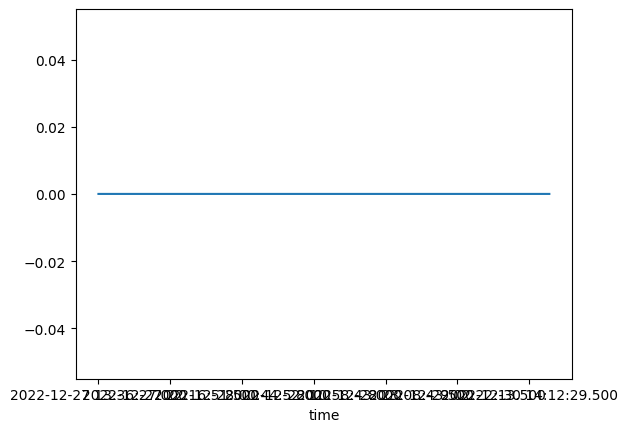

3470/3470 [==============================] - 9s 3ms/step
              short  neutral  long
true_short      0.0  16440.0   0.0
true_neutral    0.0  66524.0   0.0
true_long       0.0  20851.0   0.0
              short   neutral  long
true_short      NaN  0.158359   NaN
true_neutral    NaN  0.640794   NaN
true_long       NaN  0.200848   NaN


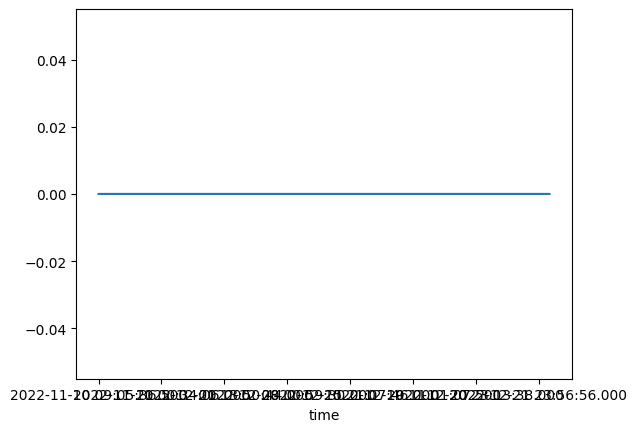

3470/3470 [==============================] - 9s 3ms/step
              short  neutral  long
true_short      0.0    42083   0.0
true_neutral    3.0   150826   0.0
true_long       1.0    49225   0.0
              short   neutral  long
true_short     0.00  0.173800   NaN
true_neutral   0.75  0.622903   NaN
true_long      0.25  0.203297   NaN


,long_wealth,short_wealth,pred_short,pred_neutral,pred_long,trade_returns
time,,,,,,
2022-11-10 09:05:36.500,0.999504,1.000496,0.255902,0.457502,0.286596,0
2022-11-10 09:05:37.500,0.999504,1.000447,0.255772,0.457599,0.286630,0
2022-11-10 09:05:38.000,0.999454,1.000496,0.255506,0.457794,0.286700,0
2022-11-10 09:05:38.500,0.999504,1.000496,0.255400,0.457898,0.286702,0
2022-11-10 09:05:39.000,0.999454,1.000397,0.254934,0.458259,0.286807,0
...,...,...,...,...,...,...
2022-12-22 02:24:54.500,1.000000,0.999806,0.209179,0.542890,0.247932,0
2022-12-22 02:24:55.000,0.999903,0.999757,0.207099,0.545299,0.247602,0
2022-12-22 02:24:55.500,0.999951,0.999854,0.203084,0.548001,0.248915,0


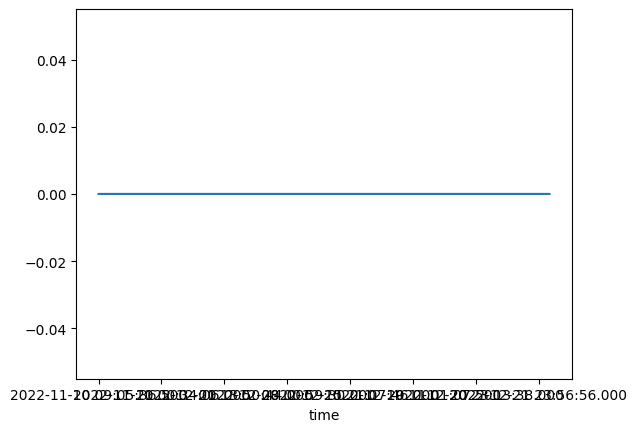

In [66]:
output_list = []
for sq in big_batch_sequence_list:
    for X, y in sq:
        output = model.predict(X, verbose=1)
        confusion += get_confusion(y, output)
        output_list.append(output)
print(confusion)
print(confusion/confusion.sum(0))
plot_pnl(output_list, big_batch_sequence_list, uptrend_chunk_list)

In [ ]:
stop

In [ ]:
chunk_list_gen = get_chunk_list_gen(hp.training_week+1, skip_to=hp.skip_to, end=hp.end)

conf_list = []

for i, chunk_list in enumerate(chunk_list_gen):

    train_chunk = concat_chunk(*chunk_list[:hp.training_week])
    walk_forward_chunk = chunk_list[-1]

    morning_train_chunk, afternoon_train_chunk, night_train_chunk = split_market(train_chunk)
    morning_wf_chunk, afternoon_wf_chunk, night_wf_chunk = split_market(walk_forward_chunk)

    print(make_class(night_train_chunk.label, 1.0000).mean())

    X_list = []
    y_list = []

    epsilon=1.0000

    for i, chunk in enumerate([morning_train_chunk, afternoon_train_chunk, night_train_chunk]):
        X = chunk.lob.loc[:, hp.features]
        y = make_class(chunk.label, epsilon)
        X = X.reindex(y.index)
        y = y.reindex(X.index)
        X_list.append(X)
        y_list.append(y)

    scaler = StandardScaler()
    scaler.fit(pd.concat(X_list))

    sp_generator_list = []

    for i, chunk in enumerate([morning_train_chunk, afternoon_train_chunk, night_train_chunk]):

        X = chunk.lob.loc[:, hp.features]
        X = pd.DataFrame(scaler.transform(X), index=X.index, columns=X.columns)
        y = make_class(chunk.label, epsilon)
        X = X.reindex(y.index)
        y = y.reindex(X.index)
        #transform y here

        sp_generator : List[stride_data.SequencePair] = stride_data.create_train_val_sequence_cv(
            X, y, cv=hp.cv, lookback=hp.lookback, 
            batch_size=hp.batch_size, batch_no=hp.batch_no[i], 
            shuffle=hp.shuffle, trim=hp.trim, replace=hp.replace)

        sp_generator_list.append(sp_generator)

    wf_sequence_list = []

    for i, chunk in enumerate([morning_wf_chunk, afternoon_wf_chunk, night_wf_chunk]):

        X = chunk.lob.loc[:, hp.features]
        X = pd.DataFrame(scaler.transform(X), index=X.index, columns=X.columns)
        y = make_class(chunk.label, epsilon)
        X = X.reindex(y.index)
        y = y.reindex(X.index)
        #transform y here

        wf_sequence : stride_data.StrideData = stride_data.StrideData(X, y, lookback=hp.lookback, 
                                                batch_size=y.shape[0] - hp.lookback, batch_no=None, 
                                                shuffle=False, replace=False)

        wf_sequence_list.append(wf_sequence)

    early_stopper = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=50,
        verbose=1,
        mode="auto",
        baseline=None,
        restore_best_weights=False,
    )

    # for cv_count in range(hp.cv): #just have train-validation
    sp_list = [next(sp_gen) for sp_gen in sp_generator_list]
    sq = stride_data.CombinedSequence(*[sp.train_sequence for sp in sp_list], shuffle=hp.shuffle, seed=hp.seed, replace=hp.replace)
    test_tuple = np.vstack([sp.test_tuple[0] for sp in sp_list]), np.vstack([sp.test_tuple[1] for sp in sp_list])

    csv_logger = CSVLogger(fr'{base_output_folder}\callback_logs\{run_prefix}\_temp\{run_prefix}.csv')
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=hp.init_learning_rate,
        decay_steps=hp.decay_steps,
        decay_rate=hp.lr_decay)
    try:
        opt = opt_dict[hp.opt](learning_rate=lr_schedule)
    except Exception:
        print(f"{hp.opt} does not work with scheduler")
        opt = opt_dict[hp.opt](learning_rate=hp.init_learning_rate)

    # model = tf.keras.Sequential()
    # for l, p in schematic_dict[hp.schematic]:
    #     model.add(l(**p))
        
    # model.add(layers.Dense(3, activation='softmax')) # add output node

    model_maker = model_maker_dict[hp.schematic]

    model = model_maker(hp.lookback, len(hp.features), hp.lob_unit, hp.inception_unit, hp.lstm_unit)

    model.compile(loss=loss_dict[hp.loss], optimizer=opt, metrics=[], weighted_metrics=[])
    # with tf.device('/cpu:0'):
    model.fit(x=sq,
            use_multiprocessing=False,
            validation_data=test_tuple,
            epochs=hp.epochs,
            verbose=1,
            callbacks=[csv_logger, early_stopper])

    confusion = pd.DataFrame(0, 
                            index=['true_short', 'true_neutral', 'true_long'],
                            columns=['short', 'neutral', 'long'])
    for wf in wf_sequence_list:
        output = model.predict(wf[0][0])
        confusion += get_confusion(wf[0][1], output)
    conf_list.append(confusion)

In [ ]:
print(conf_list)

In [ ]:
wf_sequence_list[0].get_target_indices(0)

In [ ]:
confusion = pd.DataFrame(0, 
                        index=['true_short', 'true_neutral', 'true_long'],
                        columns=['short', 'neutral', 'long'])
for wf in wf_sequence_list:
    output = model.predict(wf[0][0])
    confusion += get_confusion(wf[0][1], output)

print(confusion)
print(confusion/confusion.sum())